In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [8]:
#Basic Information
df = pd.read_csv('healthcare-dataset-stroke-data.csv.xls')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [10]:
#Handling missing values
df.isnull().sum()
df['bmi'].fillna(df['bmi'].median())

0       36.6
1       28.1
2       32.5
3       34.4
4       24.0
        ... 
5105    28.1
5106    40.0
5107    30.6
5108    25.6
5109    26.2
Name: bmi, Length: 5110, dtype: float64

In [12]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

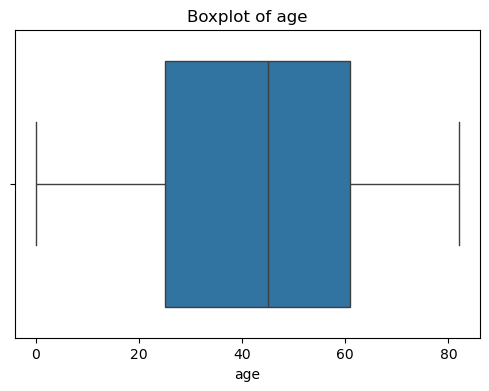

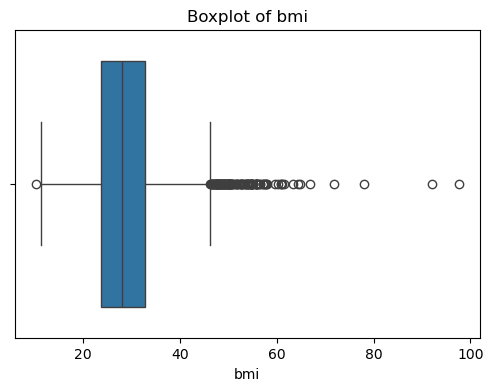

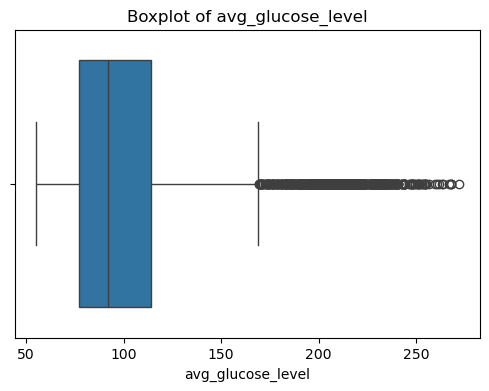

In [14]:
#Handing outliers 
#age seems to have no outliers
#BMI: significant right skew, values < 45
#Glucose: significantly right skewed 
continous_cols = ['age', 'bmi', 'avg_glucose_level']
for col in continous_cols:
   plt.figure(figsize=(6,4))
   sns.boxplot(data=df, x=col)
   plt.title(f'Boxplot of {col}')
   plt.show()

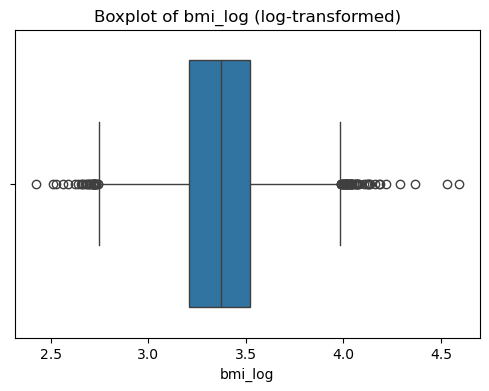

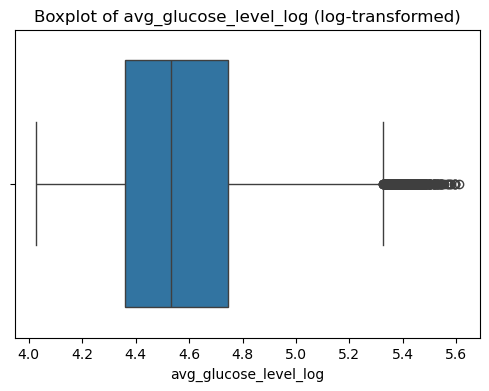

In [16]:
#Log transformation to handle skewness 
df['bmi_log'] = np.log1p(df['bmi'])
df['avg_glucose_level_log'] = np.log1p(df['avg_glucose_level'])

for col in ['bmi_log', 'avg_glucose_level_log']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, data=df)
    plt.title(f"Boxplot of {col} (log-transformed)")
    plt.show()

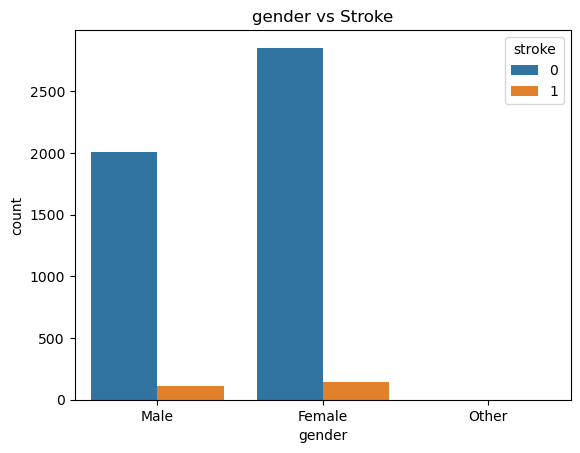

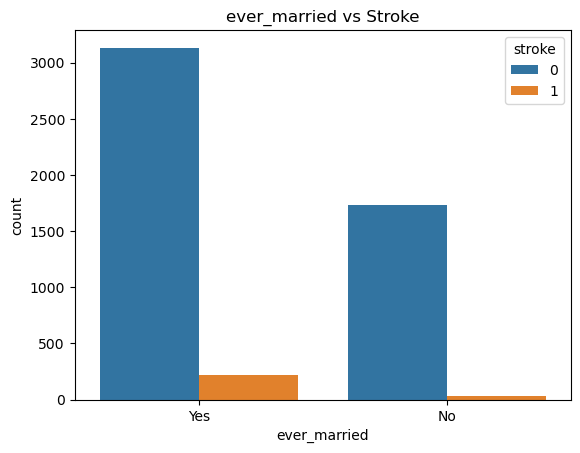

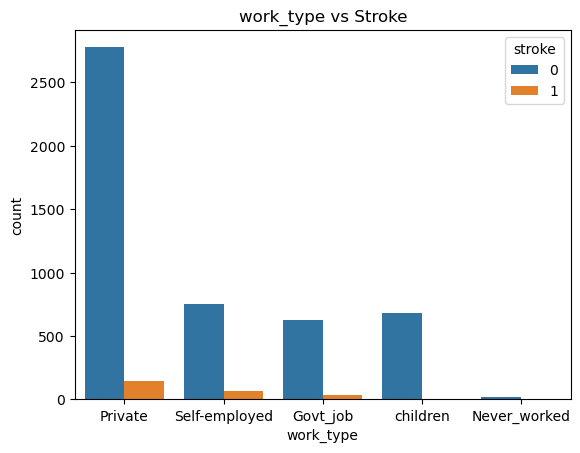

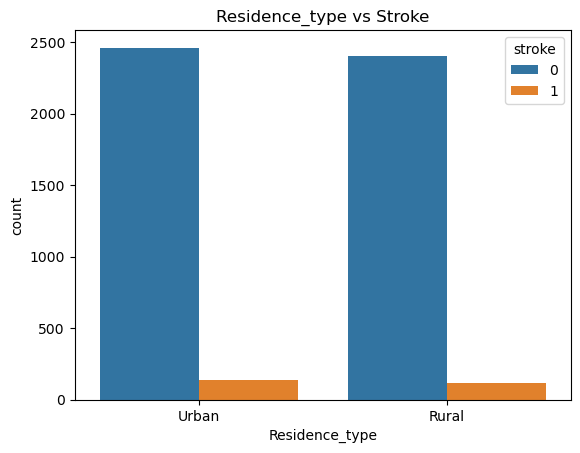

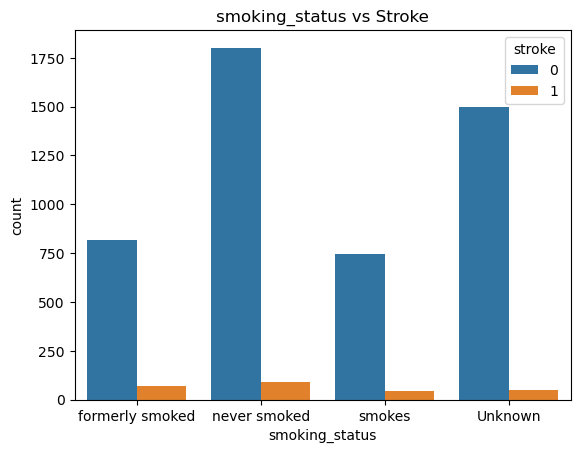

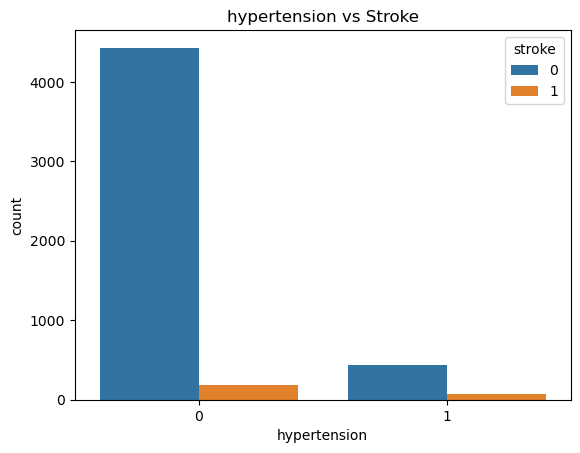

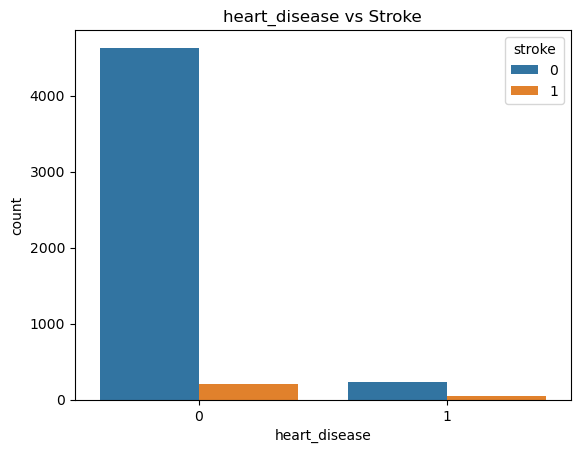


Stroke percentage by gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64

Stroke percentage by ever_married:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64

Stroke percentage by work_type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64

Stroke percentage by Residence_type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64

Stroke percentage by smoking_status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64

Stroke percentage by hypertension:
hypertension
0     3.967910
1    13.253012
Name: stroke, dtype: float64

Stroke percentage by heart_disease:
heart_disease
0     4.178734
1    17.028986
Name: stroke, dtype: float64


In [20]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
for col in categorical_cols:
    sns.countplot(x=col, hue='stroke', data=df)
    plt.title(f"{col} vs Stroke")
    plt.show()
for col in categorical_cols:
    s_proportions = df.groupby(col)['stroke'].mean()*100
    print(f"\nStroke percentage by {col}:\n{s_proportions}")

In [24]:
df_encoded = pd.get_dummies(df.drop('id', axis=1), drop_first=True)
print("\nEncoded columns:", df_encoded.columns)


Encoded columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'bmi_log', 'avg_glucose_level_log', 'gender_Male',
       'gender_Other', 'ever_married_Yes', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [26]:
#Random Forest Model: doing a baseline model as a starting point
#Based on results: highly imbalanced, (-5% stroke cases)- biased towards majority (stroke = No)
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

In [28]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [30]:
def train_evaluate_rf(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return model

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



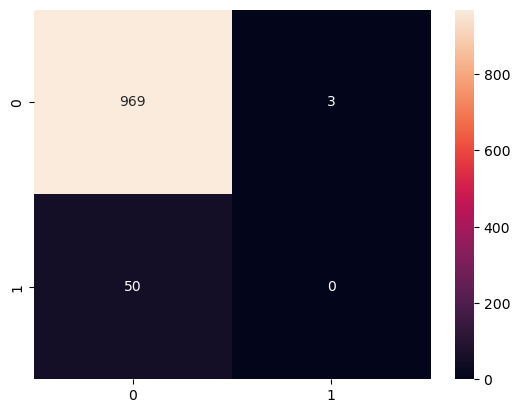

In [32]:
rf_model = train_evaluate_rf(X_train, y_train, X_test, y_test)